# ConflictWiki Network v0.1

Aggregated dyad network; nodes represent entities, edges represent aggregated conflicts between entities, edge line width represents number of conflicts, edge colouring represents relationship (green – allies, yellow – number of times being allies and enemies is equal, red – enemies)

### load external libraries

In [21]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import networkx as nx
import random

## Load data

### Nodes (Entities)

In [20]:
node_list_file = pathlib.Path().parent.absolute().parent / "mappings" / "network" / "node_list.pkl"
node_list = pd.read_pickle(node_list_file)

### Edges (Conflicts)

In [22]:
aggr_edge_list_file = pathlib.Path().parent.absolute().parent / "mappings" / "network" / "aggr_edge_list.pkl"
aggr_edge_list = pd.read_pickle(aggr_edge_list_file)

# Create network

In [27]:
def edge_colouring(G):
    
    edge_features_colours = dict()
    for k, v in nx.get_edge_attributes(G, 'label_continuous').items():
        if v > 0:
            edge_features_colours[k] = "green"
        if v <= 0:
            edge_features_colours[k] = "red"
            
    nx.set_edge_attributes(G, edge_features_colours, "label_colour")
    return G
            
def edge_widths(G, min_width = 1, max_width = 20):
    
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    def scale_list(l, to_min, to_max):
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]
    
    counts = scale_list(list(nx.get_edge_attributes(G, "n_conflicts").values()),min_width,max_width)
    return counts

def sample_node_labels(node_list, label_percentage = 0.05):    
    
    node_list_labels = list()
    
    for (entity_id, entity_attr) in node_list:
        
        if random.uniform(0, 1) < label_percentage: ## randomly assign edge lables
            entity_attr["name_display"] = entity_attr["name"] 
        else:
            entity_attr["name_display"] = "" 
        node_list_labels.append((entity_id, entity_attr))
        
    return node_list_labels

def sample_edges(G, n_edges = 500):
    sampled_edges = random.sample(G.edges, n_edges)
    return G.edge_subgraph(sampled_edges)

def sample_edges_by_width(G, min_edge_width = 2):
    edge_width_dict = nx.get_edge_attributes(G, "n_conflicts")
    sampled_edges = [edge for edge, width in edge_width_dict.items() if width > min_edge_width]
    return G.edge_subgraph(sampled_edges)

def sample_nodes(G, n_nodes = 500):
    sampled_nodes = random.sample(G.nodes, n_nodes)
    return G.subgraph(sampled_nodes)

In [28]:
G = nx.Graph()
node_list = sample_node_labels(node_list, label_percentage = 0.5)
G.add_nodes_from(node_list)
G.add_edges_from(aggr_edge_list)

#G = sample_edges(G, n_edges= 500)
G = sample_edges_by_width(G, min_edge_width = 5)
#G = sample_nodes(G, n_nodes= 100)

Gc = max(nx.connected_components(G), key=len) ## get largest connected subgraph
G = G.subgraph(Gc).copy()

In [29]:
G = edge_colouring(G)
edge_width = edge_widths(G, min_width = 2, max_width = 20)

node_labels = nx.get_node_attributes(G, 'name_display')
sign_colour = nx.get_edge_attributes(G, 'label_colour').values()

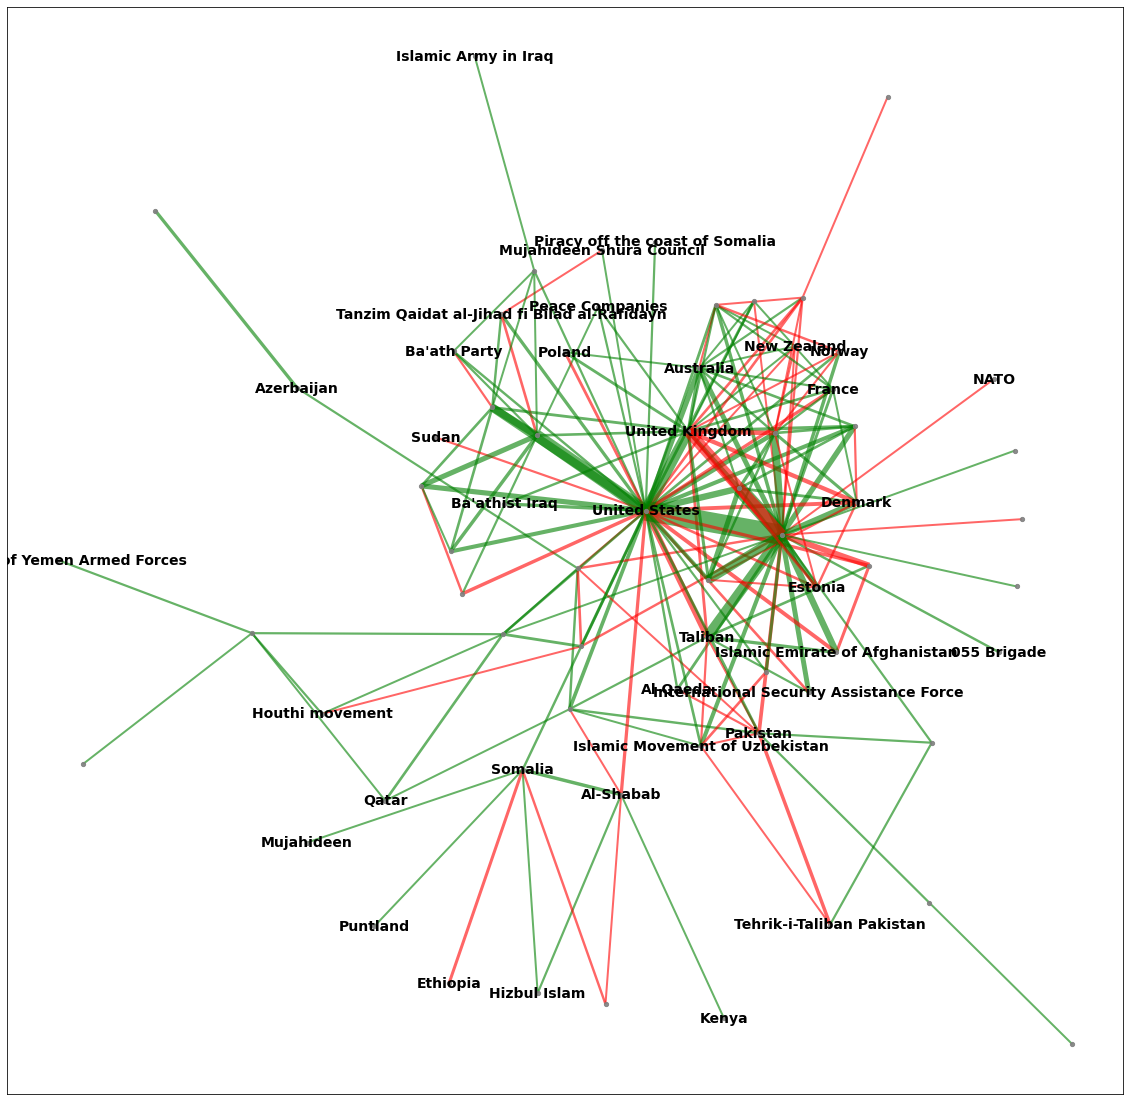

In [30]:
pos = nx.kamada_kawai_layout(G)#, weight = 'label_discrete', scale=1)
plt.figure(figsize=(20,20)) 

nx.draw_networkx_nodes(G, pos, alpha=0.9, node_color="grey", node_size = 18)
nx.draw_networkx_labels(G, pos, node_labels, font_size=14, font_weight = "bold", font_color='black')
nx.draw_networkx_edges(G, pos, width = edge_width, alpha=0.6, edge_color=sign_colour, edge_cmap=plt.get_cmap('RdYlGn'))